In [1]:
#데이터 구성
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

%matplotlib inline

import seaborn as sns

In [2]:
df_sales = pd.read_csv("./sales_detail.csv", engine = "python", parse_dates=["order_yearmonth","order_date","supply_date"],encoding = 'UTF8')

In [3]:
# purchase_cnt (구매 개수) 가 0인 데이터(26개) 제외
df_sales = df_sales[df_sales["purchase_cnt"]!=0]
# sales_detail 11~17
# total_amt(구매 수*단가), compare(total_amt - purchase_amt) 컬럼 생성
df_sales["total_amt"] = df_sales["purchase_cnt"]*df_sales["unit_cost"]
df_sales["compare"]= df_sales["total_amt"] - df_sales["purchase_amt"]
# 0인 데이터 없애기
df_sales.query('purchase_cnt!=0', inplace=True)

In [304]:
print("19년도~19년도의판매 상품 수 :",len(df_sales.item_name.unique()))

19년도~19년도의판매 상품 수 : 1454


In [240]:
print("대분류 :", len(df_sales.item_g_l.unique()))
print("중분류 :", len(df_sales.item_g_m.unique()))
print("소분류 :", len(df_sales.item_g_s.unique()))

대분류 : 6
중분류 : 38
소분류 : 299


In [305]:
df_item = pd.DataFrame(df_sales.groupby(['item_g_l','item_g_m','item_g_s']).item_name.unique())
df_item

item_name
item_g_l item_g_m item_g_s                                                    
간식       과자       스낵         [꼬마찹쌀모나카(112g/8개), 누룽지(500g), 매일견과(25g*10봉), 오...
                  엿/양갱/기타    [땅콩사탕(70g), 고구마양갱(40g), 팥양갱(40g), 단호박양갱(40g), ...
                  쿠키         [녹차쿠키(100g), 호두쿠키(100g), 흑미쌀쿠키(100g), 단호박쿠키(10...
                  한과/유과      [한과모음3(1.2kg), 약과(200g/18개), 찹쌀유과(120g), 방울유과(...
         떡        가래떡          [말랑말랑백미가래떡(400g), 냉동밀떡볶이떡(500g), 조랭이떡(유기/500g)]
...                                                                        ...
축산물      한우       대용량물품(정육)  [한우불고기(1kg/국내산), 닭다리순살(1kg/국내산), 한우국거리(600g/국내...
                  안심대안한우     [★한우등심(안심대안/300g/신선육), 양지국거리용(안심대안/200g/신선육), ...
                  유기한우       [한우국거리/유기(600g국내산), 곱게다진한우순살(유기/200g/국내산), 한우안...
                  일반 한우      [한우분쇄육(300g/국내산), 한우불고기(600g/국내산), 한우샤브샤브(300g...
                  한우         [한우국거리/조각(300g/국내산), 한우잡채용(200g/국내산), 한우카레용(20...

[329 rows x 1 columns]

* 2년간 총 판매 갯수를 세고, 상위 40개에 대해 유사한 상품을 찾아보자

In [310]:
total_cnt = pd.DataFrame(df_sales.groupby('item_name').purchase_cnt.sum())
total_cnt.sort_values(by='purchase_cnt')

,purchase_cnt
item_name,
삼겹살 냉장500g/통-제주,1
메론(중/1.2~1.5kg/1통/하니원),1
절단무(1kg 이상),1
오이맛풋고추(500g),1
단팥빵(60g/매점),1
...,...
조아농장 토종유정란(10알) -제주,4461
두부(1모:420g),4583
구운도시락김(5g*3봉),5660


In [320]:
# 상위 40개 item name 저장
most_pop_item = total_cnt.sort_values(by='purchase_cnt').tail(40).index[::-1]

##### item corpus를 만들자.
* 장바구니에 같이 담겼다면 유사한 상품으로 판단한다. 같이 담긴 상품들을 하나의 list에 넣고 word2vec을 통해 유사성을 계산한다.

In [242]:
item_corpus = df_sales.groupby("order_id").apply(lambda x: x.item_name.tolist()).values.tolist()
item_corpus[:5]

[['꼬마찹쌀모나카(112g/8개)', '제주전통어간장(500ml)', '맛간장(900ml)'],
 ['엿기름가루(무/500g)', '메주가루(500g)', '쌀조청(500g)', '찹쌀가루(500g)', '표고가루(60g)'],
 ['도토리가루(500g)'],
 ['두부(1모:400g)참이든-제주', '육개장(700g)', '누룽지(500g)'],
 ['한과모음3(1.2kg)']]

* total_cnt를 정렬한 결과에서도 볼 수 있듯이 2년간 1회만 판매된 상품도 존재한다.
* 최소 5번 이상 같이 등장한 상품의 경우만 유의하다고 판단하자.(min_count=5)

In [434]:
from gensim.models import Word2Vec
model = Word2Vec(item_corpus,seed=1238,workers=1)

* 유사한 상품과 유사도를 출력한다. 유사도는 4번째 자리에서 반올림한다.

In [435]:
def most_similar_item(model, item_name):
    similar_list = model.wv.most_similar(item_name)
    return pd.DataFrame([(item_name,1.00)] + [(i,round(j,3)) for i,j in similar_list],columns=["item_","similarity"])

* 가장 많이 팔린 40개 제품에 대해 유사한 상품을 출력해보자

In [436]:
most_similar_item(model, "구운전장김(40g)")

,item_,similarity
0,구운전장김(40g),1.000
1,돈가스소스(240g),0.981
2,오징어동그랑어묵(270g),0.960
3,자장가루(100g),0.956
4,현미유(500ml),0.955
5,단무지(반찬용:400g),0.953
6,카레(매운맛: 100g),0.953
7,네모난햄(500g)-매장,0.952
8,우리밀빵가루(190g),0.950
9,둥근긴어묵(270g),0.946


In [390]:
for i in most_pop_item:
    print(most_similar_item(model, i))
    print()

                item_  similarity
0   두부(1모:400g)참이든-제주       1.000
1          찹쌀가루(500g)       0.941
2          조선된장(900g)       0.938
3           볶은소금(1kg)       0.936
4           흰밀가루(1kg)       0.936
5       냉동현미떡국떡(500g)       0.930
6     순두부(400g)참이든-제주       0.927
7          분쇄육500g-제주       0.924
8          굴소스(220ml)       0.922
9    다진마늘/난지형(유:200g)       0.917
10         메밀가루(500g)       0.915

                item_  similarity
0     순두부(400g)참이든-제주       1.000
1          생콩가루(250g)       0.987
2          조선된장(900g)       0.978
3          들깨가루(200g)       0.978
4          들기름(330ml)       0.977
5           청국장(150g)       0.976
6           청국장(250g)       0.970
7            당면(500g)       0.964
8           연근채(300g)       0.939
9   두부(1모:400g)참이든-제주       0.927
10         찹쌀가루(500g)       0.910

                item_  similarity
0       구운도시락김(5g*3봉)       1.000
1        튀김옷돈가스(400g)       0.983
2       소고기동그랑땡(400g)       0.979
3       네모난햄(500g)-매장       0.975
4          소

# 순두부 + 생콩가루/들깨가루 + 된장/청국장 = 된장찌개 또는 청국장 패키지
* 생콩가루나 들깨가루 : 국이나 죽을 끓일 때 고소해지도록 넣는다 !
* 된장, 청국장 : 된장찌개나 청국장을 만들기 위해 구매하는 것으로 추정해볼 수 있다

In [398]:
most_similar_item(model, "순두부(400g)참이든-제주")

,item_,similarity
0,순두부(400g)참이든-제주,1.000
1,생콩가루(250g),0.987
2,조선된장(900g),0.978
3,들깨가루(200g),0.978
4,들기름(330ml),0.977
5,청국장(150g),0.976
6,청국장(250g),0.970
7,당면(500g),0.964
8,연근채(300g),0.939
9,두부(1모:400g)참이든-제주,0.927


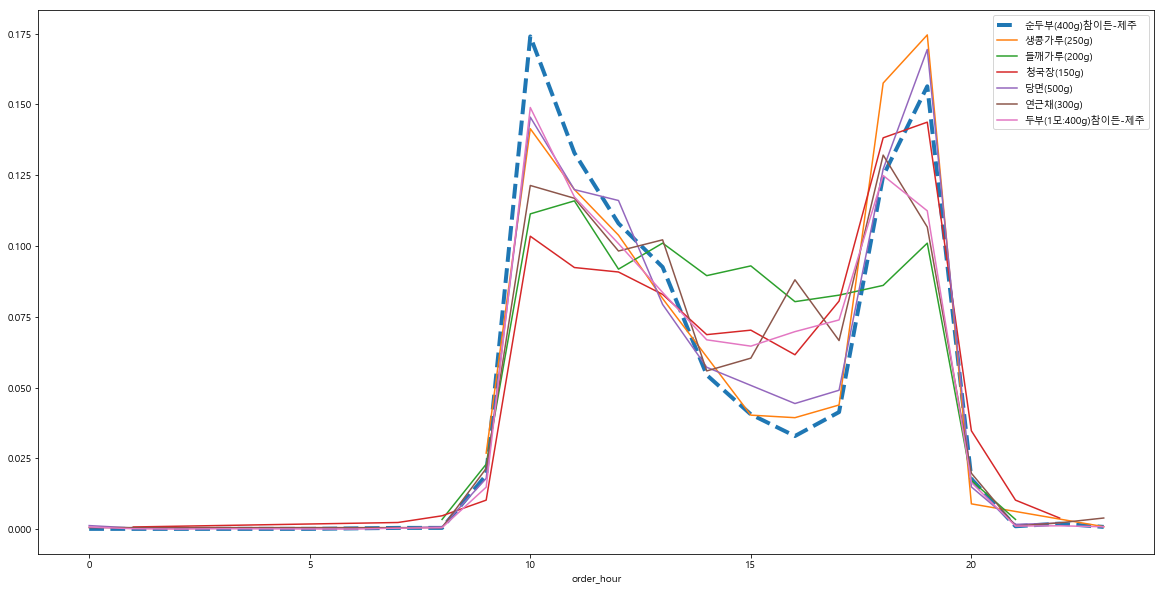

In [495]:
item = '순두부(400g)참이든-제주'
(df_sales.query(f'item_name=="{item}"').groupby('order_hour').purchase_cnt.sum()/df_sales.query(f'item_name=="{item}"').purchase_cnt.sum()).plot(style="--",figsize=(20,10),legend=True,label=item, linewidth=4)
for i in [i for i,j in model.wv.most_similar(f'{item}')]:
    if total_cnt.loc[i,'purchase_cnt']>800:
        (df_sales.query(f'item_name=="{i}"').groupby('order_hour').purchase_cnt.sum()/df_sales.query(f'item_name=="{i}"').purchase_cnt.sum()).plot(legend=True,label=i)

* 순두부와 함께 팔리는 상품들은 주로 오전 10시, 오후 7시에 많이 구매함.
* "오늘의 점심메뉴/오늘의 저녁메뉴" : 오늘 점심/저녁에는 된장찌개를 곁들이는건 어떠세요? : 패키지 상품 판매

# 구운 전장김 + 김밥 재료 + 돈가스 재료 = 소풍/나들이용!
* 전장김이란? 자르지 않은 상태의 김을 말함. 즉 도시락김이 아닌 큰 사이즈의 김!  
  
    
1. 돈가스 소스, 우리밀 빵가루, 현미유  
  * 왜 나왔을까? 김밥과 돈가스를 함께 준비하는건 아닐까? 
  * 손수 음식을 준비해서 나들이를 떠나는건 아닐까?
> 한번 살펴보자
2. 동그랑 어묵
> 밥반찬 혹은 도시락 반찬으로 어묵 볶음을 떠올려볼 수 있다.
3. 긴 어묵, 네모난햄, 단무지
> 전형적인 김밥 재료
7. 윈너소시지
> 소시지 역시 도시락에 빠질 수 없는 반찬이다! 

### 날씨가 좋은 날 소풍 패키지 판매
* "손수 만드는 소풍 도시락" => 김밥재료, 돈가스 재료, 도시락 반찬 + 케찹, 돈가스소스 등 소스류를 함께 묶어 판매
* 소풍 패키지를 구매하여 직접 만들고 사진을 올리면 추첨을 통해 제주 관광지 할인권/무료 입장권을 제공한다.
> 패키지 홍보 + 지역 경제 활성화 두가지를 잡을 수 있지 않을까?
  
  
* 소스류나 빵가루, 대용량 단무지 등은 도시락을 꾸리고 나면 많은 양이 남게 됨.
부담이 없도록 용량이 적은 재료를 함께 판매하면 좋을듯 !!
  

### 손수 만드는 소풍 패키지와 가볍게 꾸리는 소풍 패키지 두가지를 준비
* 직접 돈가스를 만들기 부담스러운 사람들에게는 이미 조리된 냉동 식품을 추천

In [437]:
most_similar_item(model, "구운전장김(40g)")

,item_,similarity
0,구운전장김(40g),1.000
1,돈가스소스(240g),0.981
2,오징어동그랑어묵(270g),0.960
3,자장가루(100g),0.956
4,현미유(500ml),0.955
5,단무지(반찬용:400g),0.953
6,카레(매운맛: 100g),0.953
7,네모난햄(500g)-매장,0.952
8,우리밀빵가루(190g),0.950
9,둥근긴어묵(270g),0.946


* 빵가루와 등심/돈가스가 함께 담기고 있다 !
* 빵가루는 확인 결과 등심/돈가스용과 함께 담기고 있다.

In [438]:
most_similar_item(model, "우리밀빵가루(190g)")

,item_,similarity
0,우리밀빵가루(190g),1.000
1,고기만두(1.5kg),0.977
2,조랭이떡(유기/800g),0.974
3,잡곡식빵(450g),0.974
4,진간장(900ml-원액간장),0.973
5,현미도너츠가루(540g),0.971
6,카레(매운맛: 100g),0.971
7,네모난햄(500g)-매장,0.970
8,등심/돈가스용500g-제주,0.969
9,돈가스소스(240g),0.969


In [425]:
most_similar_item(model, "돈가스소스(240g)")

,item_,similarity
0,돈가스소스(240g),1.000
1,구운전장김(40g),0.981
2,현미유(500ml),0.974
3,채소교자만두(500g),0.971
4,오징어동그랑어묵(270g),0.970
5,우리밀빵가루(190g),0.969
6,사리면(100g),0.963
7,단무지(반찬용:400g),0.957
8,네모난햄(500g)-매장,0.957
9,진간장(900ml-원액간장),0.957


In [477]:
most_similar_item(model,"단무지(반찬용:400g)")

,item_,similarity
0,단무지(반찬용:400g),1.000
1,돈육곡물소시지(300g)-매장,0.989
2,오징어동그랑어묵(270g),0.988
3,우동(471g),0.987
4,현미쌀가스(320g),0.986
5,후랑크소시지(300g)-매장,0.985
6,불고기양념소시지(300g)-매장,0.984
7,유기농토마토케찹(250g),0.983
8,핫케이크가루(600g),0.983
9,햄버거스테이크(80g*5),0.982


# 구운 도시락김 + 조리된 반찬 = 손쉬운 식사용!
* 전장김과는 다르게 조리만 하면 완성되는 식품을 함께 구매하고 있음 (너비아니, 돈가스, 동그랑땡 등)
* 소풍용 도시락 재료와는 약간 거리가 먼 스프, 소면이 있는 것으로 보아 집에서 식사를 준비할 때 주로 구매할것으로 추측됨.

In [456]:
most_similar_item(model, "구운도시락김(5g*3봉)")

,item_,similarity
0,구운도시락김(5g*3봉),1.000
1,현미쌀너비아니(200g),0.988
2,치즈돈가스(300g),0.987
3,소고기스프(80g),0.983
4,포도잼(280g),0.982
5,우유또띠아(40g*10장),0.982
6,소고기동그랑땡(400g),0.982
7,현미쌀가스(320g),0.981
8,우리밀색동소면(400g),0.980
9,카스텔라(소:100g),0.979


# 우유, 요구르트, 아이스크림, 빵은 비슷한 위치에 진열하자
* 함께 담기는 경우가 많으므로 한꺼번에 쇼핑하며 구매할 수 있도록 배치.
* 매장이 문을 닫기 전, 유통기한이 임박한 우유와 그날 구운 빵을 함께 묶어 판매한다면 더 좋지 않을까?

In [405]:
most_similar_item(model, "블루베리요구르트(120ml)")

,item_,similarity
0,블루베리요구르트(120ml),1.000
1,우유(범산/200ml),0.917
2,★카스텔라(소:100g)/매장,0.917
3,소보로빵(75g)/매장,0.904
4,크루아상(150g)/매장,0.899
5,★크림빵(75g)/매장,0.897
6,★우유식빵(180g)/매장,0.891
7,구운유정란(6알),0.890
8,소보루빵(75g)/매장,0.884
9,소보로단팥빵(90g)/매장,0.883


In [407]:
most_similar_item(model,"★유기농우유(종이팩/900ml)")

,item_,similarity
0,★유기농우유(종이팩/900ml),1.000
1,잡곡식빵(450g)/매장,0.931
2,★쌀식빵(360g)/매장,0.930
3,목초우유(200ml*3병),0.926
4,떠먹는 요거트(90g*2개),0.922
5,통밀식빵(300g)/매장,0.922
6,★우유식빵(180g)/매장,0.917
7,구운유정란(6알),0.913
8,떠먹는요거트(350g),0.913
9,유정란/매장용(6알/국내산),0.908


In [474]:
most_similar_item(model,"아이스바우유(75ml)")

,item_,similarity
0,아이스바우유(75ml),1.000
1,유기농블루베리아이스바(70ml),0.976
2,아이스바딸기(75ml),0.963
3,유기농요거트딸기아이스크림(100ml),0.930
4,유기농플레인요거트아이스크림(100ml),0.919
5,유기농아이스크림(기본형),0.797
6,★크림빵(75g)/매장,0.788
7,크루아상(150g)/매장,0.764
8,소보루빵(75g)/매장,0.748
9,★콩콩크림빵(90g/매장),0.741


In [475]:
most_similar_item(model,"★크림빵(75g)/매장")

,item_,similarity
0,★크림빵(75g)/매장,1.000
1,★카스텔라(소:100g)/매장,0.983
2,크루아상(150g)/매장,0.976
3,소보로빵(75g)/매장,0.971
4,소보루빵(75g)/매장,0.953
5,★콩콩크림빵(90g/매장),0.952
6,소보로단팥빵(90g)/매장,0.935
7,유기농플레인요거트아이스크림(100ml),0.925
8,유기농아이스크림(기본형),0.923
9,우유(범산/200ml),0.922
